In [ ]:
  !pip install tensorflow_federated
  !pip install privacy_meter
  !pip install opacus

In [ ]:
import tensorflow as tf
import tensorflow_federated as tff

from privacy_meter.audit import Audit, MetricEnum
from privacy_meter.constants import InferenceGame
from privacy_meter.dataset import Dataset
from privacy_meter.information_source import InformationSource
from privacy_meter.model import TensorflowModel
from privacy_meter.audit_report import ROCCurveReport, SignalHistogramReport
from privacy_meter import audit_report

In [ ]:
number_of_points_for_training = 1000
number_of_points_for_test = 1000
num_population_points = 5000
fpr_tolerance_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Federation Learning
num_clients = 5
num_rounds = 200

In [ ]:
# Load and preprocess your dataset
(train_images_all, train_labels_all), (test_images_all, test_labels_all) = tf.keras.datasets.cifar10.load_data()

train_images = train_images_all[:number_of_points_for_training]
train_labels = train_labels_all[:number_of_points_for_training]
test_images = test_images_all[:number_of_points_for_test]
test_labels = test_labels_all[:number_of_points_for_test]
x_population = train_images_all[number_of_points_for_training:(number_of_points_for_training + num_population_points)]
y_population = train_labels_all[number_of_points_for_training:(number_of_points_for_training + num_population_points)]

# Normalize samples
train_images, test_images, x_population = train_images / 255.0, test_images / 255.0, x_population / 255.0

In [ ]:
def preprocess(dataset):
    def batch_format_fn(element):
        return (tf.expand_dims(element['x'], -1), element['y'])
    return dataset.batch(64).map(batch_format_fn)

def make_federated_data(images, labels, num_clients):
    """Creates a federated dataset from images and labels."""
    client_data = []
    total_data = len(images)
    client_data_size = total_data // num_clients
    for client_id in range(num_clients):
        start = client_id * client_data_size
        end = (client_id + 1) * client_data_size if client_id != num_clients - 1 else total_data
        client_data.append(
            tf.data.Dataset.from_tensor_slices(
                {'x': images[start:end], 'y': labels[start:end]}
            )
        )
    return [preprocess(data) for data in client_data]

In [ ]:
# CNN model
def create_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [ ]:
def model_fn():
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=federated_train_data[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
federated_train_data = make_federated_data(train_images, train_labels, num_clients)


In [ ]:
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.1),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.9)
)

In [ ]:
state = iterative_process.initialize()

In [ ]:
for round_num in range(num_rounds):
    state, metrics = iterative_process.next(state, federated_train_data)
    print(f'Round {round_num + 1}, Metrics={metrics}')

Round 1, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.779), ('loss', 0.6561505), ('num_examples', 1000), ('num_batches', 20)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 2, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.757), ('loss', 0.6992079), ('num_examples', 1000), ('num_batches', 20)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Round 3, Metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.755), ('loss', 0.69112474), ('num_examples', 1000), ('num_batches', 20)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDic

In [ ]:
final_model_weights = iterative_process.get_model_weights(state)
trained_model = create_keras_model()
final_model_weights.assign_weights_to(trained_model)

In [ ]:
train_ds = {'x': train_images, 'y': train_labels}
test_ds = {'x': test_images, 'y': test_labels}

target_dataset = Dataset(
    data_dict={'train': train_ds, 'test': test_ds},
    default_input='x', default_output='y'
)

population_ds = {'x': x_population, 'y': y_population}
reference_dataset = Dataset(
    data_dict={'train': population_ds},
    default_input='x', default_output='y'
)

In [ ]:
target_model = TensorflowModel(model_obj=trained_model, loss_fn=tf.keras.losses.SparseCategoricalCrossentropy())

In [ ]:
target_info_source = InformationSource(
    models=[target_model],
    datasets=[target_dataset]
)

reference_info_source = InformationSource(
    models=[target_model],
    datasets=[reference_dataset]
)

In [ ]:
audit_obj = Audit(
    metrics=MetricEnum.POPULATION,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    fpr_tolerances=fpr_tolerance_list
)
audit_obj.prepare()
audit_results = audit_obj.run()[0]



self.accuracy = np.mean(predicted_labels == true_labels, axis=1)
self.tn = np.sum(true_labels == 0) - np.sum(
    predicted_labels[:, true_labels == 0], axis=1
)
self.tp = np.sum(predicted_labels[:, true_labels == 1], axis=1)
self.fp = np.sum(predicted_labels[:, true_labels == 0], axis=1)
self.fn = np.sum(true_labels == 1) - np.sum(
    predicted_labels[:, true_labels == 1], axis=1
)

self.roc_auc = auc(
    self.fp / (np.sum(true_labels == 0)), self.tp / (np.sum(true_labels == 1))
)

Results are stored in: ['/content/log_2024-08-19_10-58-14-000']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# plt.figure(figsize=(2, 2))
# plt.title(train_labels[10])
# plt.axis('off')
# plt.imshow(train_images[10])



In [ ]:
# index = 4
# image = np.expand_dims(train_images[index], axis=0)

# a = tf.data.Dataset.from_tensor_slices({'x': train_images[0:0], 'y': train_labels[0:0]})
# res = target_model.get_loss([image], [train_labels[index]])
# print(res)
# print(audit_results[0].true_labels[index])predicted_labels
difference_indices = np.where(audit_results[0].true_labels != audit_results[0].predicted_labels)[0]
print(difference_indices.shape
      )

(7937,)


In [ ]:
for result in audit_results:
    print(result)

============= METRIC RESULT OBJECT =============
Accuracy          = 0.5
ROC AUC Score     = 0.8207180000000001
FPR               = 0.0
TN, FP, FN, TP    = (1000, 0, 1000, 0)

============= METRIC RESULT OBJECT =============
Accuracy          = 0.63
ROC AUC Score     = 0.8207180000000001
FPR               = 0.093
TN, FP, FN, TP    = (907, 93, 647, 353)

============= METRIC RESULT OBJECT =============
Accuracy          = 0.7275
ROC AUC Score     = 0.8207180000000001
FPR               = 0.206
TN, FP, FN, TP    = (794, 206, 339, 661)

============= METRIC RESULT OBJECT =============
Accuracy          = 0.7645
ROC AUC Score     = 0.8207180000000001
FPR               = 0.309
TN, FP, FN, TP    = (691, 309, 162, 838)

============= METRIC RESULT OBJECT =============
Accuracy          = 0.7475
ROC AUC Score     = 0.8207180000000001
FPR               = 0.427
TN, FP, FN, TP    = (573, 427, 78, 922)

============= METRIC RESULT OBJECT =============
Accuracy          = 0.723
ROC AUC Score     = 0

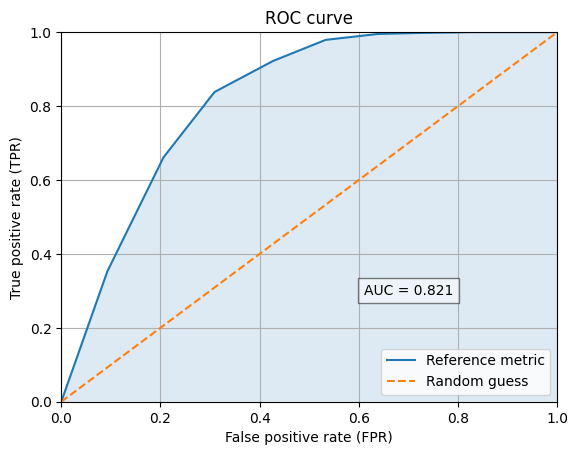

AUC = 0.821


<Figure size 640x480 with 0 Axes>

In [ ]:
ROCCurveReport.generate_report(
    metric_result=audit_results[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

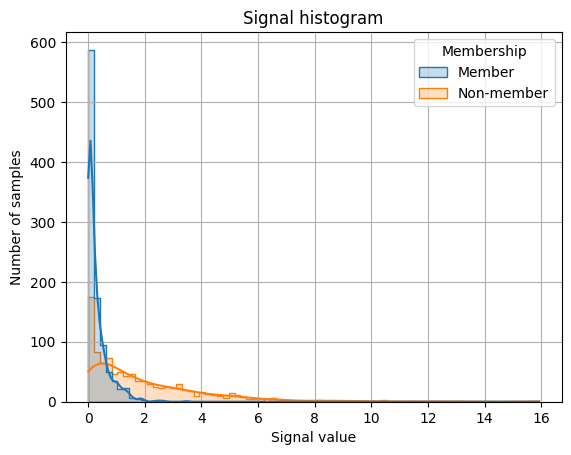

<Figure size 640x480 with 0 Axes>

In [ ]:
SignalHistogramReport.generate_report(
    metric_result=audit_results[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)